In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5"  # Only GPUs 0 and 1 will be visible to TensorFlow

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:3", "/gpu:4","/gpu:5"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

2024-10-23 01:13:31.416249: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 01:13:31.428835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 01:13:31.441372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 01:13:31.445158: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 01:13:31.456030: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5')


2024-10-23 01:13:33.575108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:4e:00.0, compute capability: 8.0
2024-10-23 01:13:33.576649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79196 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:4f:00.0, compute capability: 8.0
2024-10-23 01:13:33.577998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79196 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c5:00.0, compute capability: 8.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [3]:

# -----------------------------
# DataLoader Class Definition
# -----------------------------
class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='o',s=5)  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / np.max(centers)

        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


In [4]:

# -----------------------------
# Utility Function Definition
# -----------------------------
def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image.T

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [1, 0]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 31, 
                transposed_midpoints_corrected[:, :, 1] * 31, 
                c='red', marker='o', s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()

# -----------------------------
# Custom Loss and Callback Definitions
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent, increment, update_frequency):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


my NEW model

In [6]:
from tensorflow.keras import layers, regularizers
import tensorflow as tf

class ModelBuilder:
    def __init__(self, input_shape=(32, 32, 1), num_classes=5, num_coordinates=2, learning_rate=1e-3, weights_path=None, l1_reg=0.001, l2_reg=0.01):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def build_model(self):
        
        l1 = regularizers.l1(self.l1_reg)
        l2 = regularizers.l2(self.l2_reg)
        
        # # CBAM Attention Block
        # def cbam_block(input_tensor, reduction_ratio=16):
        #     """CBAM block, which includes channel and spatial attention"""
        #     # Channel Attention
        #     channel_attention = layers.GlobalAveragePooling2D()(input_tensor)
        #     channel_attention = layers.Reshape((1, 1, input_tensor.shape[-1]))(channel_attention)
        #     channel_attention = layers.Dense(input_tensor.shape[-1] // reduction_ratio, activation='relu')(channel_attention)
        #     channel_attention = layers.Dense(input_tensor.shape[-1], activation='sigmoid')(channel_attention)
        #     x = layers.Multiply()([input_tensor, channel_attention])

        #     # Spatial Attention
        #     avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
        #     max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
        #     concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
        #     spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
        #     x = layers.Multiply()([x, spatial_attention])

        #     return x
    
        x_input = layers.Input(shape=self.input_shape)
        
        x = layers.Conv2D(512, kernel_size=19, padding='same', activation='relu')(x_input)
       
        
        x = layers.Flatten()(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [7]:

# -----------------------------
# Main Script Execution
# -----------------------------

# Load data
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_Mixed_13.h5'             
h5_filename = '/home/da886/Final Electron counting project/Images and Labels/13KFixed_Mixed_5_32by32_95indexFor19kernel.h5'
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_13_SparsespotsRandomIndex.h5'
# h5_filename ='/home/da886/Final Electron counting project/Images and Labels/30KFixed-index6_13.h5'
data_loader = DataLoader(h5_filename)
images, centers = data_loader.load_data()


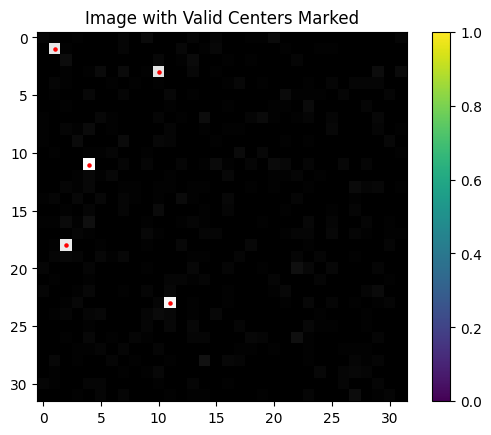

(<matplotlib.image.AxesImage at 0x7efc546ff2c0>, 8071)

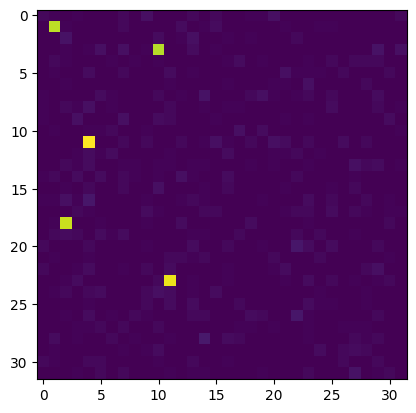

In [8]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l]),l
# plt.grid(True),l

(<matplotlib.image.AxesImage at 0x7f17b8157d90>, 5501)

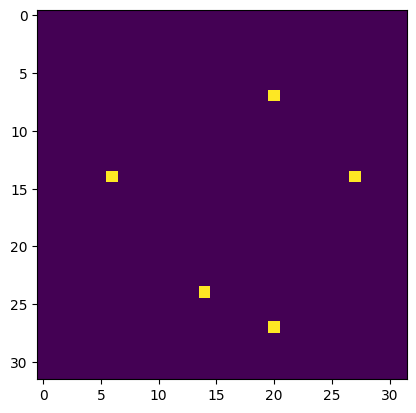

In [9]:
plt.imshow(images[l]),l

In [15]:
t = np.random.randint(0,len(centers))
centers[t]

array([[ 1.,  6.,  2.],
       [ 1., 27., 30.],
       [ 1., 27., 13.],
       [ 1., 27., 31.],
       [ 1.,  9.,  5.]], dtype=float32)

In [9]:

# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))


In [10]:
np.min(train_images), np.max(train_images), np.min(train_midpoints), np.max(train_midpoints)

(0.0, 1.0, 0.0, 1.0)

In [10]:
np.max(centers)

31.0

In [11]:

batch_size = 1000
train_dataset = train_dataset.shuffle(buffer_size=8000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=8000).batch(batch_size)

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (10400, 32, 32), Train Midpoints: (10400, 1, 5, 2)
Validation Images: (2600, 32, 32), Validation Midpoints: (2600, 1, 5, 2)


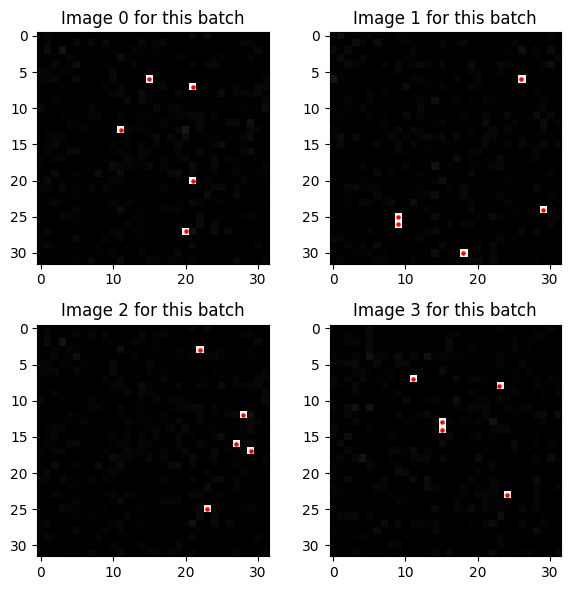

In [12]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [14]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=10, verbose=1, mode='min', min_lr=7e-6
)


In [13]:

# dynamic_exponent_callback = DynamicExponentCallback(2, 1, 400)


with strategy.scope():
    model_builder = ModelBuilder()

    model_builder.build_model()

    model_builder.model.summary()

    model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError()) 
  




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 512)    │       185,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints (Dense)             │ (None, 10)             │     5,242,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints_reshape (Reshape)   │ (None, 1, 5, 2)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,428,234 (20.71 MB)

 Trainable params: 5,428,234 (20.71 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:

# Train the model with the custom callback
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=2000,
    callbacks_list=[lr_scheduler]
)


Epoch 1/2000


2024-10-23 01:14:41.580546: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-10-23 01:14:43.491110: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1729646083.568214 1761512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646083.577845 1761523 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646083.582629 1761519 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646083.591707 1761512 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646083.599423 1761519 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646083.606969 1761523 gpu_timer.cc

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0800

2024-10-23 01:14:45.937733: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-10-23 01:14:45.937825: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
W0000 00:00:1729646085.949269 1761507 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646085.951636 1761507 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646085.954940 1761507 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646085.961846 1761507 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646085.974664 1761507 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0792

W0000 00:00:1729646086.364597 1761511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646086.810728 1761506 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646086.821436 1761508 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646086.829987 1761511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646086.838515 1761506 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646086.847039 1761508 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646086.856271 1761511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646086.865450 1761506 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729646086.874917 1761508 gp

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 405ms/step - loss: 0.0785 - val_loss: 0.0561 - learning_rate: 0.0010
Epoch 2/2000


W0000 00:00:1729646089.276508 1761508 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0527

2024-10-23 01:14:50.247878: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0519 - val_loss: 0.0401 - learning_rate: 0.0010
Epoch 3/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0368 - val_loss: 0.0309 - learning_rate: 0.0010
Epoch 4/2000


2024-10-23 01:14:51.646905: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0307 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 5/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0268 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 6/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0255

2024-10-23 01:14:54.889842: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0254 - val_loss: 0.0254 - learning_rate: 0.0010
Epoch 7/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0248 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 8/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0245 - val_loss: 0.0252 - learning_rate: 0.0010
Epoch 9/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0239 - val_loss: 0.0258 - learning_rate: 0.0010
Epoch 10/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0234 - val_loss: 0.0247 - learning_rate: 0.0010
Epoch 11/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0228 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 12/2000


2024-10-23 01:15:01.025723: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0225 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 13/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0220 - val_loss: 0.0254 - learning_rate: 0.0010
Epoch 14/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0218 - val_loss: 0.0254 - learning_rate: 0.0010
Epoch 15/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0213 - val_loss: 0.0252 - learning_rate: 0.0010
Epoch 16/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0207 - val_loss: 0.0250 - learning_rate: 0.0010
Epoch 17/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0205 - val_loss: 0.0250 - learning_rate: 0.0010
Epoch 18/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0198 - val_loss: 0.0242 - learning_rate: 0.0010
Epoch 19/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0191 - val_loss: 0.0235 - learning_rate: 0.0010
Epoch 20/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0190 - val_loss: 0.0237 - learning_rate: 0.0010
Epoch 

2024-10-23 01:15:11.585636: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0187 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 22/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0179

2024-10-23 01:15:13.536520: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0179 - val_loss: 0.0225 - learning_rate: 0.0010
Epoch 23/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0174 - val_loss: 0.0235 - learning_rate: 0.0010
Epoch 24/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0170 - val_loss: 0.0233 - learning_rate: 0.0010
Epoch 25/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0168 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 26/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0163 - val_loss: 0.0227 - learning_rate: 0.0010
Epoch 27/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0161 - val_loss: 0.0224 - learning_rate: 0.0010
Epoch 28/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0156 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 29/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0151 - val_loss: 0.0231 - learning_rate: 0.0010
Epoch 30/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0147 - val_loss: 0.0220 - learning_rate: 0.0010
Epoch 

2024-10-23 01:15:38.456725: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0086 - val_loss: 0.0226 - learning_rate: 9.0000e-04
Epoch 45/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0083 - val_loss: 0.0226 - learning_rate: 9.0000e-04
Epoch 46/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0078 - val_loss: 0.0220 - learning_rate: 9.0000e-04


2024-10-23 01:15:41.874381: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 47/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0073 - val_loss: 0.0234 - learning_rate: 9.0000e-04
Epoch 48/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0072 - val_loss: 0.0234 - learning_rate: 9.0000e-04
Epoch 49/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0070 - val_loss: 0.0222 - learning_rate: 9.0000e-04
Epoch 50/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0065 - val_loss: 0.0226 - learning_rate: 9.0000e-04
Epoch 51/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0061 - val_loss: 0.0242 - learning_rate: 9.0000e-04
Epoch 52/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0061
Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0063 - val_loss: 0.0228 - learning_rate: 9.0000e-04
Epoch 53/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0058 - val_loss: 0.0229 - learning_rate: 8.1000e-04
Epoch 54/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - 

2024-10-23 01:16:12.517950: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0021 - val_loss: 0.0232 - learning_rate: 7.2900e-04
Epoch 73/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0021 - val_loss: 0.0232 - learning_rate: 7.2900e-04
Epoch 74/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0020 - val_loss: 0.0223 - learning_rate: 7.2900e-04
Epoch 75/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0019 - val_loss: 0.0223 - learning_rate: 7.2900e-04
Epoch 76/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0019 - val_loss: 0.0220 - learning_rate: 7.2900e-04
Epoch 77/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0020
Epoch 77: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0020 - val_loss: 0.0235 - learning_rate: 7.2900e-04
Epoch 78/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0020 - val_loss: 0.0230 - learning_rate: 6.5610e-04
Epoch 79/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0019 -

2024-10-23 01:16:29.383881: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0013
Epoch 87: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0013 - val_loss: 0.0234 - learning_rate: 6.5610e-04
Epoch 88/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0012 - val_loss: 0.0243 - learning_rate: 5.9049e-04
Epoch 89/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0012 - val_loss: 0.0225 - learning_rate: 5.9049e-04
Epoch 90/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0011 - val_loss: 0.0224 - learning_rate: 5.9049e-04
Epoch 91/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0011 - val_loss: 0.0227 - learning_rate: 5.9049e-04
Epoch 92/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0010 - val_loss: 0.0223 - learning_rate: 5.9049e-04
Epoch 93/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 9.8149e-04 - val_loss: 0.0233 - learning_rate: 5.9049e-04
Epoch 94/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 9.55

2024-10-23 01:16:42.530617: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 8.5140e-04 - val_loss: 0.0239 - learning_rate: 5.3144e-04
Epoch 99/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 8.3171e-04 - val_loss: 0.0234 - learning_rate: 5.3144e-04
Epoch 100/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 8.2182e-04 - val_loss: 0.0231 - learning_rate: 5.3144e-04
Epoch 101/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.8620e-04 - val_loss: 0.0234 - learning_rate: 5.3144e-04
Epoch 102/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.5807e-04 - val_loss: 0.0234 - learning_rate: 5.3144e-04
Epoch 103/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.5672e-04 - val_loss: 0.0239 - learning_rate: 5.3144e-04
Epoch 104/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.3579e-04 - val_loss: 0.0234 - learning_rate: 5.3144e-04
Epoch 105/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 7.2087e-04 - val_loss: 0.0239 - learning_rate: 5.3144e-04
Epoch 106/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91m

2024-10-23 01:17:12.997945: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 124/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.5165e-04 - val_loss: 0.0244 - learning_rate: 4.3047e-04
Epoch 125/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.5086e-04 - val_loss: 0.0239 - learning_rate: 4.3047e-04
Epoch 126/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.5509e-04 - val_loss: 0.0251 - learning_rate: 4.3047e-04
Epoch 127/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 4.2462e-04
Epoch 127: ReduceLROnPlateau reducing learning rate to 0.00038742052274756136.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.3129e-04 - val_loss: 0.0243 - learning_rate: 4.3047e-04
Epoch 128/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.2444e-04 - val_loss: 0.0236 - learning_rate: 3.8742e-04
Epoch 129/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.1984e-04 - val_loss: 0.0243 - learning_rate: 3.8742e-04
Epoch 130/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.1731e-04 - val_loss: 0.0245 - learning_rate: 3.8742e-04
Epoch 131/2000


2024-10-23 01:17:43.649741: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.0012e-04 - val_loss: 0.0249 - learning_rate: 3.1381e-04
Epoch 150/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.9917e-04 - val_loss: 0.0240 - learning_rate: 3.1381e-04
Epoch 151/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 2.9247e-04 - val_loss: 0.0238 - learning_rate: 3.1381e-04
Epoch 152/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.8988e-04 - val_loss: 0.0241 - learning_rate: 3.1381e-04
Epoch 153/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.8745e-04 - val_loss: 0.0238 - learning_rate: 3.1381e-04
Epoch 154/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.7944e-04 - val_loss: 0.0234 - learning_rate: 3.1381e-04
Epoch 155/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.7911e-04 - val_loss: 0.0241 - learning_rate: 3.1381e-04
Epoch 156/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.7384e-04 - val_loss: 0.0240 - learning_rate: 3.1381e-04
Epoch 157/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 67

2024-10-23 01:18:11.041439: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.2730e-04 - val_loss: 0.0243 - learning_rate: 2.5419e-04
Epoch 173/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.2081e-04 - val_loss: 0.0246 - learning_rate: 2.5419e-04
Epoch 174/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.2149e-04 - val_loss: 0.0242 - learning_rate: 2.5419e-04
Epoch 175/2000


2024-10-23 01:18:13.793775: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 2.1809e-04 - val_loss: 0.0242 - learning_rate: 2.5419e-04
Epoch 176/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.2006e-04 - val_loss: 0.0243 - learning_rate: 2.5419e-04
Epoch 177/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.0911e-04
Epoch 177: ReduceLROnPlateau reducing learning rate to 0.00022876793809700757.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.1245e-04 - val_loss: 0.0251 - learning_rate: 2.5419e-04
Epoch 178/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.1761e-04 - val_loss: 0.0238 - learning_rate: 2.2877e-04
Epoch 179/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.1121e-04 - val_loss: 0.0226 - learning_rate: 2.2877e-04
Epoch 180/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.0891e-04 - val_loss: 0.0255 - learning_rate: 2.2877e-04
Epoch 181/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.1074e-04 - val_loss: 0.0248 - learning_rate: 2.2877e-04
Epoch 182/2000
11/11 ━━━━━━━━━

2024-10-23 01:18:44.584042: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 1.8156e-04 - val_loss: 0.0259 - learning_rate: 1.8530e-04
Epoch 201/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.7208e-04 - val_loss: 0.0245 - learning_rate: 1.8530e-04
Epoch 202/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.7395e-04 - val_loss: 0.0243 - learning_rate: 1.8530e-04
Epoch 203/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.7849e-04 - val_loss: 0.0243 - learning_rate: 1.8530e-04
Epoch 204/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.7288e-04 - val_loss: 0.0244 - learning_rate: 1.8530e-04
Epoch 205/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.6877e-04 - val_loss: 0.0252 - learning_rate: 1.8530e-04
Epoch 206/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.6955e-04 - val_loss: 0.0245 - learning_rate: 1.8530e-04
Epoch 207/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.6818e-04
Epoch 207: ReduceLROnPlateau reducing learning rate to 0.00016677183302817866.
11/11 ━━━━━━━━━

2024-10-23 01:19:15.351775: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.4583e-04 - val_loss: 0.0248 - learning_rate: 1.5009e-04
Epoch 227/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.4683e-04
Epoch 227: ReduceLROnPlateau reducing learning rate to 0.0001350851875031367.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.4885e-04 - val_loss: 0.0250 - learning_rate: 1.5009e-04
Epoch 228/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.4355e-04 - val_loss: 0.0250 - learning_rate: 1.3509e-04
Epoch 229/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.4267e-04 - val_loss: 0.0261 - learning_rate: 1.3509e-04
Epoch 230/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.4601e-04 - val_loss: 0.0237 - learning_rate: 1.3509e-04
Epoch 231/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.4459e-04 - val_loss: 0.0255 - learning_rate: 1.3509e-04
Epoch 232/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 1.4416e-04 - val_loss: 0.0253 - learning_rate: 1.3509e-04
Epoch 233/2000
11/11 ━━━━━━━━━━

2024-10-23 01:19:45.366823: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.2572e-04 - val_loss: 0.0253 - learning_rate: 1.0942e-04
Epoch 253/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.2490e-04 - val_loss: 0.0250 - learning_rate: 1.0942e-04
Epoch 254/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.2561e-04 - val_loss: 0.0254 - learning_rate: 1.0942e-04
Epoch 255/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.2500e-04 - val_loss: 0.0240 - learning_rate: 1.0942e-04
Epoch 256/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.2576e-04 - val_loss: 0.0240 - learning_rate: 1.0942e-04
Epoch 257/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.2368e-04
Epoch 257: ReduceLROnPlateau reducing learning rate to 9.847709443420172e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.2574e-04 - val_loss: 0.0257 - learning_rate: 1.0942e-04
Epoch 258/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.2335e-04 - val_loss: 0.0257 - learning_rate: 9.8477e-05
Epoch 259/2000
11/11 ━━━━━━━━━━

2024-10-23 01:20:15.449114: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.1269e-04
Epoch 277: ReduceLROnPlateau reducing learning rate to 7.976644701557234e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.1404e-04 - val_loss: 0.0244 - learning_rate: 8.8629e-05
Epoch 278/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.1650e-04 - val_loss: 0.0240 - learning_rate: 7.9766e-05
Epoch 279/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.1359e-04 - val_loss: 0.0245 - learning_rate: 7.9766e-05
Epoch 280/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.1197e-04 - val_loss: 0.0253 - learning_rate: 7.9766e-05
Epoch 281/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.1241e-04 - val_loss: 0.0253 - learning_rate: 7.9766e-05
Epoch 282/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.1179e-04 - val_loss: 0.0248 - learning_rate: 7.9766e-05
Epoch 283/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.1361e-04 - val_loss: 0.0249 - learning_rate: 7.9766e-05
Epoch 284/2000
11/11 ━━━━━━━━━━

2024-10-23 01:20:45.942477: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 303/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.0338e-04 - val_loss: 0.0245 - learning_rate: 6.4611e-05
Epoch 304/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.0341e-04 - val_loss: 0.0263 - learning_rate: 6.4611e-05
Epoch 305/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.0301e-04 - val_loss: 0.0252 - learning_rate: 6.4611e-05
Epoch 306/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.0465e-04 - val_loss: 0.0255 - learning_rate: 6.4611e-05
Epoch 307/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.0343e-04
Epoch 307: ReduceLROnPlateau reducing learning rate to 5.8149741380475466e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.0507e-04 - val_loss: 0.0243 - learning_rate: 6.4611e-05
Epoch 308/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 1.0453e-04 - val_loss: 0.0249 - learning_rate: 5.8150e-05
Epoch 309/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.0260e-04 - val_loss: 0.0266 - learning_rate: 5.8150e-05
Epoch 310/2000


2024-10-23 01:21:16.103874: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 9.6367e-05 - val_loss: 0.0247 - learning_rate: 4.7101e-05
Epoch 329/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 9.7267e-05 - val_loss: 0.0253 - learning_rate: 4.7101e-05
Epoch 330/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 9.7317e-05 - val_loss: 0.0257 - learning_rate: 4.7101e-05
Epoch 331/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 9.6171e-05 - val_loss: 0.0250 - learning_rate: 4.7101e-05
Epoch 332/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 9.7031e-05 - val_loss: 0.0249 - learning_rate: 4.7101e-05
Epoch 333/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 9.3356e-05 - val_loss: 0.0248 - learning_rate: 4.7101e-05
Epoch 334/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 9.6832e-05 - val_loss: 0.0254 - learning_rate: 4.7101e-05
Epoch 335/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 9.2881e-05 - val_loss: 0.0258 - learning_rate: 4.7101e-05
Epoch 336/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91

2024-10-23 01:21:35.232402: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 9.7365e-05 - val_loss: 0.0248 - learning_rate: 4.2391e-05
Epoch 345/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 9.2339e-05 - val_loss: 0.0252 - learning_rate: 4.2391e-05
Epoch 346/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 9.2265e-05 - val_loss: 0.0249 - learning_rate: 4.2391e-05
Epoch 347/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 9.0658e-05
Epoch 347: ReduceLROnPlateau reducing learning rate to 3.815204618149437e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 9.2738e-05 - val_loss: 0.0245 - learning_rate: 4.2391e-05
Epoch 348/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 9.2351e-05 - val_loss: 0.0250 - learning_rate: 3.8152e-05
Epoch 349/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 9.2121e-05 - val_loss: 0.0256 - learning_rate: 3.8152e-05
Epoch 350/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 9.2840e-05 - val_loss: 0.0254 - learning_rate: 3.8152e-05
Epoch 351/2000
11/11 ━━━━━━━━━━

2024-10-23 01:21:46.951498: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 9.0845e-05 - val_loss: 0.0253 - learning_rate: 3.8152e-05
Epoch 354/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 9.4807e-05 - val_loss: 0.0243 - learning_rate: 3.8152e-05
Epoch 355/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 8.7594e-05 - val_loss: 0.0252 - learning_rate: 3.8152e-05
Epoch 356/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 9.1454e-05 - val_loss: 0.0250 - learning_rate: 3.8152e-05
Epoch 357/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 8.8630e-05
Epoch 357: ReduceLROnPlateau reducing learning rate to 3.4336842873017304e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 9.0167e-05 - val_loss: 0.0247 - learning_rate: 3.8152e-05
Epoch 358/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 9.2535e-05 - val_loss: 0.0257 - learning_rate: 3.4337e-05
Epoch 359/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 9.2992e-05 - val_loss: 0.0255 - learning_rate: 3.4337e-05
Epoch 360/2000
11/11 ━━━━━━━━━

2024-10-23 01:22:17.040929: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 8.7505e-05 - val_loss: 0.0236 - learning_rate: 2.7813e-05
Epoch 380/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 8.8302e-05 - val_loss: 0.0256 - learning_rate: 2.7813e-05
Epoch 381/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 8.6146e-05 - val_loss: 0.0242 - learning_rate: 2.7813e-05
Epoch 382/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 8.7925e-05 - val_loss: 0.0250 - learning_rate: 2.7813e-05
Epoch 383/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 8.6996e-05 - val_loss: 0.0250 - learning_rate: 2.7813e-05
Epoch 384/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 8.5550e-05 - val_loss: 0.0248 - learning_rate: 2.7813e-05
Epoch 385/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 8.8338e-05 - val_loss: 0.0247 - learning_rate: 2.7813e-05
Epoch 386/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 8.6255e-05 - val_loss: 0.0257 - learning_rate: 2.7813e-05
Epoch 387/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68

2024-10-23 01:22:47.859479: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 8.6149e-05 - val_loss: 0.0250 - learning_rate: 2.2528e-05
Epoch 405/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 8.3035e-05 - val_loss: 0.0255 - learning_rate: 2.2528e-05
Epoch 406/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 8.2828e-05 - val_loss: 0.0252 - learning_rate: 2.2528e-05
Epoch 407/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 8.3497e-05
Epoch 407: ReduceLROnPlateau reducing learning rate to 2.0275563474569936e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 8.4339e-05 - val_loss: 0.0257 - learning_rate: 2.2528e-05
Epoch 408/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 8.3403e-05 - val_loss: 0.0258 - learning_rate: 2.0276e-05
Epoch 409/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 8.3775e-05 - val_loss: 0.0247 - learning_rate: 2.0276e-05
Epoch 410/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 8.3766e-05 - val_loss: 0.0267 - learning_rate: 2.0276e-05
Epoch 411/2000
11/11 ━━━━━━━━━

2024-10-23 01:23:17.874307: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 8.0188e-05 - val_loss: 0.0250 - learning_rate: 1.6423e-05
Epoch 431/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 8.2621e-05 - val_loss: 0.0248 - learning_rate: 1.6423e-05
Epoch 432/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.9974e-05 - val_loss: 0.0259 - learning_rate: 1.6423e-05
Epoch 433/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 8.0891e-05 - val_loss: 0.0245 - learning_rate: 1.6423e-05
Epoch 434/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.9502e-05 - val_loss: 0.0237 - learning_rate: 1.6423e-05
Epoch 435/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 7.8369e-05 - val_loss: 0.0246 - learning_rate: 1.6423e-05
Epoch 436/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.9187e-05 - val_loss: 0.0249 - learning_rate: 1.6423e-05
Epoch 437/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 7.9041e-05
Epoch 437: ReduceLROnPlateau reducing learning rate to 1.4780885430809576e-05.
11/11 ━━━━━━━━━

2024-10-23 01:23:48.011951: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 7.8781e-05 - val_loss: 0.0252 - learning_rate: 1.3303e-05
Epoch 456/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 8.1334e-05 - val_loss: 0.0258 - learning_rate: 1.3303e-05
Epoch 457/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 8.0167e-05
Epoch 457: ReduceLROnPlateau reducing learning rate to 1.1972517313552089e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 8.0767e-05 - val_loss: 0.0253 - learning_rate: 1.3303e-05
Epoch 458/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.9267e-05 - val_loss: 0.0247 - learning_rate: 1.1973e-05
Epoch 459/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.9665e-05 - val_loss: 0.0257 - learning_rate: 1.1973e-05
Epoch 460/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 8.0184e-05 - val_loss: 0.0254 - learning_rate: 1.1973e-05
Epoch 461/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.9509e-05 - val_loss: 0.0253 - learning_rate: 1.1973e-05
Epoch 462/2000
11/11 ━━━━━━━━━

2024-10-23 01:24:18.659307: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.3819e-05 - val_loss: 0.0255 - learning_rate: 9.6977e-06
Epoch 481/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.8484e-05 - val_loss: 0.0243 - learning_rate: 9.6977e-06
Epoch 482/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.5961e-05 - val_loss: 0.0260 - learning_rate: 9.6977e-06
Epoch 483/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.6487e-05 - val_loss: 0.0253 - learning_rate: 9.6977e-06
Epoch 484/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.7355e-05 - val_loss: 0.0265 - learning_rate: 9.6977e-06
Epoch 485/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.8135e-05 - val_loss: 0.0261 - learning_rate: 9.6977e-06
Epoch 486/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.6289e-05 - val_loss: 0.0245 - learning_rate: 9.6977e-06
Epoch 487/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 7.6076e-05
Epoch 487: ReduceLROnPlateau reducing learning rate to 8.727965268917615e-06.
11/11 ━━━━━━━━━━

2024-10-23 01:24:48.666867: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.5302e-05 - val_loss: 0.0253 - learning_rate: 7.8552e-06
Epoch 507/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 7.3082e-05
Epoch 507: ReduceLROnPlateau reducing learning rate to 7.069651564961533e-06.
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 7.4208e-05 - val_loss: 0.0259 - learning_rate: 7.8552e-06
Epoch 508/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.3488e-05 - val_loss: 0.0246 - learning_rate: 7.0697e-06
Epoch 509/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.8300e-05 - val_loss: 0.0244 - learning_rate: 7.0697e-06
Epoch 510/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.4295e-05 - val_loss: 0.0260 - learning_rate: 7.0697e-06
Epoch 511/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.5380e-05 - val_loss: 0.0251 - learning_rate: 7.0697e-06
Epoch 512/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.8963e-05 - val_loss: 0.0260 - learning_rate: 7.0697e-06
Epoch 513/2000
11/11 ━━━━━━━━━━

2024-10-23 01:25:18.810361: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.5003e-05 - val_loss: 0.0244 - learning_rate: 7.0000e-06
Epoch 532/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.2972e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 533/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.3648e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 534/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 7.4064e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 535/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 7.3429e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 536/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.6210e-05 - val_loss: 0.0248 - learning_rate: 7.0000e-06
Epoch 537/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.3099e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 538/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.6391e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 539/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92

2024-10-23 01:25:49.235397: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 7.3243e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 557/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.1640e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 558/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.2285e-05 - val_loss: 0.0248 - learning_rate: 7.0000e-06
Epoch 559/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.2788e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 560/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.1409e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 561/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.1119e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 562/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.3199e-05 - val_loss: 0.0242 - learning_rate: 7.0000e-06
Epoch 563/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.2459e-05 - val_loss: 0.0246 - learning_rate: 7.0000e-06
Epoch 564/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91

2024-10-23 01:26:19.239861: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.0117e-05 - val_loss: 0.0245 - learning_rate: 7.0000e-06
Epoch 583/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.1485e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 584/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.3070e-05 - val_loss: 0.0247 - learning_rate: 7.0000e-06
Epoch 585/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.2065e-05 - val_loss: 0.0246 - learning_rate: 7.0000e-06
Epoch 586/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.1663e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 587/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.9333e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 588/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.0011e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 589/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.2715e-05 - val_loss: 0.0246 - learning_rate: 7.0000e-06
Epoch 590/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90

2024-10-23 01:26:50.025833: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.9155e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 608/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 7.0285e-05 - val_loss: 0.0248 - learning_rate: 7.0000e-06
Epoch 609/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.7796e-05 - val_loss: 0.0245 - learning_rate: 7.0000e-06
Epoch 610/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.9180e-05 - val_loss: 0.0246 - learning_rate: 7.0000e-06
Epoch 611/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 7.0028e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 612/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 6.9627e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 613/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.9158e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 614/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 7.0037e-05 - val_loss: 0.0248 - learning_rate: 7.0000e-06
Epoch 615/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92

2024-10-23 01:27:20.218677: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 633/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.8648e-05 - val_loss: 0.0241 - learning_rate: 7.0000e-06
Epoch 634/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.9426e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 635/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.6748e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 636/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.7729e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 637/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 6.7939e-05 - val_loss: 0.0244 - learning_rate: 7.0000e-06
Epoch 638/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.7829e-05 - val_loss: 0.0266 - learning_rate: 7.0000e-06
Epoch 639/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.8708e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 640/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.6928e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 641/2000
11/11 ━━━━━━━━━━━

2024-10-23 01:27:50.389140: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.5615e-05 - val_loss: 0.0246 - learning_rate: 7.0000e-06
Epoch 659/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.6847e-05 - val_loss: 0.0245 - learning_rate: 7.0000e-06
Epoch 660/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 6.6853e-05 - val_loss: 0.0242 - learning_rate: 7.0000e-06
Epoch 661/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.7075e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 662/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 6.5440e-05 - val_loss: 0.0266 - learning_rate: 7.0000e-06
Epoch 663/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.6795e-05 - val_loss: 0.0247 - learning_rate: 7.0000e-06
Epoch 664/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.8430e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 665/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.6703e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 666/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90

2024-10-23 01:28:21.043426: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.4915e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 684/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.7175e-05 - val_loss: 0.0244 - learning_rate: 7.0000e-06
Epoch 685/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.5464e-05 - val_loss: 0.0240 - learning_rate: 7.0000e-06
Epoch 686/2000


2024-10-23 01:28:23.540838: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.5956e-05 - val_loss: 0.0245 - learning_rate: 7.0000e-06
Epoch 687/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 6.6066e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 688/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 6.6722e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 689/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.6578e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 690/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.6376e-05 - val_loss: 0.0247 - learning_rate: 7.0000e-06
Epoch 691/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.7717e-05 - val_loss: 0.0242 - learning_rate: 7.0000e-06
Epoch 692/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.5845e-05 - val_loss: 0.0241 - learning_rate: 7.0000e-06
Epoch 693/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 6.4874e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 694/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 9

2024-10-23 01:28:51.136549: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.5519e-05 - val_loss: 0.0243 - learning_rate: 7.0000e-06
Epoch 710/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.5289e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 711/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 6.4564e-05 - val_loss: 0.0246 - learning_rate: 7.0000e-06
Epoch 712/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.5753e-05 - val_loss: 0.0248 - learning_rate: 7.0000e-06
Epoch 713/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.4757e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 714/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.4452e-05 - val_loss: 0.0245 - learning_rate: 7.0000e-06
Epoch 715/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.4495e-05 - val_loss: 0.0267 - learning_rate: 7.0000e-06
Epoch 716/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.3235e-05 - val_loss: 0.0248 - learning_rate: 7.0000e-06
Epoch 717/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90

2024-10-23 01:29:21.936658: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.1730e-05 - val_loss: 0.0268 - learning_rate: 7.0000e-06
Epoch 735/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.1526e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 736/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.3226e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 737/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.2740e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 738/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 6.2578e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 739/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.3904e-05 - val_loss: 0.0247 - learning_rate: 7.0000e-06
Epoch 740/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.3418e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 741/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.3007e-05 - val_loss: 0.0247 - learning_rate: 7.0000e-06
Epoch 742/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90

2024-10-23 01:29:52.109143: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.2056e-05 - val_loss: 0.0264 - learning_rate: 7.0000e-06
Epoch 761/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.0227e-05 - val_loss: 0.0241 - learning_rate: 7.0000e-06
Epoch 762/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.0143e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 763/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.1140e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 764/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 6.2547e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 765/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.2143e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 766/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.1288e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 767/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.9297e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 768/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90

2024-10-23 01:30:22.600942: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 786/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 6.1350e-05 - val_loss: 0.0247 - learning_rate: 7.0000e-06
Epoch 787/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 5.9134e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 788/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.8592e-05 - val_loss: 0.0269 - learning_rate: 7.0000e-06
Epoch 789/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 6.2170e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 790/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.9862e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 791/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.9402e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 792/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.9171e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 793/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.0150e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 794/2000
11/11 ━━━━━━━━━━

2024-10-23 01:30:52.621634: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.8735e-05 - val_loss: 0.0247 - learning_rate: 7.0000e-06
Epoch 812/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.8281e-05 - val_loss: 0.0261 - learning_rate: 7.0000e-06
Epoch 813/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 5.8124e-05 - val_loss: 0.0248 - learning_rate: 7.0000e-06
Epoch 814/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 5.9045e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 815/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.9011e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 816/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.9389e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 817/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 6.0335e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 818/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.7195e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 819/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 9

2024-10-23 01:31:22.691651: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.7709e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 837/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.7082e-05 - val_loss: 0.0248 - learning_rate: 7.0000e-06
Epoch 838/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 5.7779e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 839/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 5.9179e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 840/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.6313e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 841/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.7850e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 842/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.7391e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 843/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.7738e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 844/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 9

2024-10-23 01:31:53.431862: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.7729e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 863/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.5899e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 864/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.6525e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 865/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.5053e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 866/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.5314e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 867/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.3909e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 868/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.7134e-05 - val_loss: 0.0242 - learning_rate: 7.0000e-06
Epoch 869/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.6721e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 870/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91

2024-10-23 01:32:23.640971: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.4666e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 888/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.3914e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 889/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.5693e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 890/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.5116e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 891/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.5459e-05 - val_loss: 0.0246 - learning_rate: 7.0000e-06
Epoch 892/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 5.5306e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 893/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.5705e-05 - val_loss: 0.0263 - learning_rate: 7.0000e-06
Epoch 894/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 5.4190e-05 - val_loss: 0.0245 - learning_rate: 7.0000e-06
Epoch 895/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91

2024-10-23 01:32:54.420170: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.2892e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 913/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.4459e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 914/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 5.3877e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 915/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.3923e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 916/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.3856e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 917/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.3608e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 918/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.1952e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 919/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.3694e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 920/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92

2024-10-23 01:33:25.215477: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.2326e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 939/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.2862e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 940/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.2723e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 941/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.3269e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 942/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.1898e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 943/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.1746e-05 - val_loss: 0.0241 - learning_rate: 7.0000e-06
Epoch 944/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.2451e-05 - val_loss: 0.0244 - learning_rate: 7.0000e-06
Epoch 945/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.3808e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 946/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93

2024-10-23 01:33:55.293253: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.1498e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 964/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.0692e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 965/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.2253e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 966/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 5.1568e-05 - val_loss: 0.0248 - learning_rate: 7.0000e-06
Epoch 967/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 5.1117e-05 - val_loss: 0.0248 - learning_rate: 7.0000e-06
Epoch 968/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.9407e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 969/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.2324e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 970/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.0198e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 971/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90

2024-10-23 01:34:25.459630: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.1598e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 990/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 5.0907e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 991/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.9853e-05 - val_loss: 0.0248 - learning_rate: 7.0000e-06
Epoch 992/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.9593e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 993/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.9870e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 994/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 5.1376e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 995/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.9776e-05 - val_loss: 0.0263 - learning_rate: 7.0000e-06
Epoch 996/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 4.9230e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 997/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90

2024-10-23 01:34:56.009895: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.9746e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1015/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.6718e-05 - val_loss: 0.0246 - learning_rate: 7.0000e-06
Epoch 1016/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.8183e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 1017/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.9596e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1018/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.9068e-05 - val_loss: 0.0248 - learning_rate: 7.0000e-06
Epoch 1019/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.9467e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1020/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.9517e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 1021/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.8621e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1022/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:35:26.025951: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.5742e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1041/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.8668e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 1042/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.7599e-05 - val_loss: 0.0246 - learning_rate: 7.0000e-06
Epoch 1043/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.8001e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 1044/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.8414e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1045/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.7637e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 1046/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.6898e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 1047/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.7526e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 1048/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:35:56.206747: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.6975e-05 - val_loss: 0.0245 - learning_rate: 7.0000e-06
Epoch 1066/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.6291e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1067/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 4.6309e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 1068/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.6455e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1069/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.6640e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1070/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.6891e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 1071/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.6129e-05 - val_loss: 0.0244 - learning_rate: 7.0000e-06
Epoch 1072/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.5058e-05 - val_loss: 0.0247 - learning_rate: 7.0000e-06
Epoch 1073/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:36:26.730555: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.5971e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1091/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.6089e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1092/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.6640e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 1093/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.6935e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1094/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.7364e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 1095/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.5183e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1096/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.4934e-05 - val_loss: 0.0265 - learning_rate: 7.0000e-06
Epoch 1097/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.6527e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1098/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:36:56.877369: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.4180e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1117/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.5866e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1118/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.5040e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1119/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.5478e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1120/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.3715e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 1121/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.3230e-05 - val_loss: 0.0247 - learning_rate: 7.0000e-06
Epoch 1122/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.4487e-05 - val_loss: 0.0246 - learning_rate: 7.0000e-06
Epoch 1123/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.7010e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1124/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:37:27.766334: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 4.6404e-05 - val_loss: 0.0246 - learning_rate: 7.0000e-06
Epoch 1142/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.2694e-05 - val_loss: 0.0264 - learning_rate: 7.0000e-06
Epoch 1143/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.5367e-05 - val_loss: 0.0246 - learning_rate: 7.0000e-06
Epoch 1144/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.5279e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1145/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.4566e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1146/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 4.3911e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1147/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.2809e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1148/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.3428e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1149/2000
11/11 ━━━━━━━━━━━━━━━━━

2024-10-23 01:37:58.574396: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.2409e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 1168/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.2146e-05 - val_loss: 0.0261 - learning_rate: 7.0000e-06
Epoch 1169/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 4.3300e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 1170/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.3193e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 1171/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.2943e-05 - val_loss: 0.0263 - learning_rate: 7.0000e-06
Epoch 1172/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 4.2040e-05 - val_loss: 0.0261 - learning_rate: 7.0000e-06
Epoch 1173/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.2234e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1174/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.2733e-05 - val_loss: 0.0245 - learning_rate: 7.0000e-06
Epoch 1175/2000
11/11 ━━━━━━━━━━━━━━━━━

2024-10-23 01:38:28.720783: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.0992e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1193/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 4.1351e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 1194/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 4.1438e-05 - val_loss: 0.0265 - learning_rate: 7.0000e-06
Epoch 1195/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.3000e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 1196/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.2754e-05 - val_loss: 0.0261 - learning_rate: 7.0000e-06
Epoch 1197/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.2338e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1198/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.1005e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1199/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.0357e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 1200/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:38:58.766706: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 4.1812e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 1218/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.2259e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 1219/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.0252e-05 - val_loss: 0.0247 - learning_rate: 7.0000e-06
Epoch 1220/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.0728e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1221/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.0295e-05 - val_loss: 0.0245 - learning_rate: 7.0000e-06
Epoch 1222/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 4.2012e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1223/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 4.1230e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 1224/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.9671e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 1225/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:39:28.910391: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.1697e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1244/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.0022e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 1245/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.9039e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 1246/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 4.0313e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 1247/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.0119e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1248/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.0495e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1249/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.2018e-05 - val_loss: 0.0245 - learning_rate: 7.0000e-06
Epoch 1250/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 4.0059e-05 - val_loss: 0.0272 - learning_rate: 7.0000e-06
Epoch 1251/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:39:58.911912: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.8880e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 1269/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.9077e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 1270/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.9525e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1271/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 4.0437e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1272/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 3.8536e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1273/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.7884e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 1274/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 3.9217e-05 - val_loss: 0.0246 - learning_rate: 7.0000e-06
Epoch 1275/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.8726e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 1276/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:40:29.055770: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.8498e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1294/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.6568e-05 - val_loss: 0.0263 - learning_rate: 7.0000e-06
Epoch 1295/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.9453e-05 - val_loss: 0.0263 - learning_rate: 7.0000e-06
Epoch 1296/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.7757e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1297/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.9543e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1298/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.7675e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 1299/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 3.8052e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 1300/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.9066e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 1301/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:40:59.868735: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 3.8469e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1319/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.7928e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1320/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.7804e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 1321/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 3.7648e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1322/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 3.7562e-05 - val_loss: 0.0248 - learning_rate: 7.0000e-06
Epoch 1323/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.8334e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 1324/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.7714e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1325/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 3.8544e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1326/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:41:30.114735: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.6896e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 1344/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.5340e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1345/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.6669e-05 - val_loss: 0.0263 - learning_rate: 7.0000e-06
Epoch 1346/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.7080e-05 - val_loss: 0.0261 - learning_rate: 7.0000e-06
Epoch 1347/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.5446e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 1348/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.7340e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1349/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.5602e-05 - val_loss: 0.0241 - learning_rate: 7.0000e-06
Epoch 1350/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.6263e-05 - val_loss: 0.0247 - learning_rate: 7.0000e-06
Epoch 1351/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:42:00.225067: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.7647e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1370/2000
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.7303e-05

2024-10-23 01:42:02.515522: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.7550e-05 - val_loss: 0.0264 - learning_rate: 7.0000e-06
Epoch 1371/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.4948e-05 - val_loss: 0.0243 - learning_rate: 7.0000e-06
Epoch 1372/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.5456e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 1373/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 3.5953e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1374/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.6935e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 1375/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.6226e-05 - val_loss: 0.0265 - learning_rate: 7.0000e-06
Epoch 1376/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 3.5838e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1377/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.4492e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1378/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:42:30.479336: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.6530e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1395/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.4271e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1396/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.4566e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1397/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.5657e-05 - val_loss: 0.0263 - learning_rate: 7.0000e-06
Epoch 1398/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.6532e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1399/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.3911e-05 - val_loss: 0.0248 - learning_rate: 7.0000e-06
Epoch 1400/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.6093e-05 - val_loss: 0.0263 - learning_rate: 7.0000e-06
Epoch 1401/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.5623e-05 - val_loss: 0.0242 - learning_rate: 7.0000e-06
Epoch 1402/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:43:00.687583: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.4470e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1420/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.5184e-05 - val_loss: 0.0263 - learning_rate: 7.0000e-06
Epoch 1421/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.4065e-05 - val_loss: 0.0246 - learning_rate: 7.0000e-06
Epoch 1422/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.3702e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 1423/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 3.3598e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1424/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.5139e-05 - val_loss: 0.0267 - learning_rate: 7.0000e-06
Epoch 1425/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.4686e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 1426/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.5283e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 1427/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:43:30.891918: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.4665e-05 - val_loss: 0.0247 - learning_rate: 7.0000e-06
Epoch 1444/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.5178e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 1445/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.3837e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1446/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.3662e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1447/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.3212e-05 - val_loss: 0.0269 - learning_rate: 7.0000e-06
Epoch 1448/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.4777e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 1449/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 3.3322e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1450/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.3359e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 1451/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:44:00.917588: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.2770e-05 - val_loss: 0.0261 - learning_rate: 7.0000e-06
Epoch 1469/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.2300e-05 - val_loss: 0.0266 - learning_rate: 7.0000e-06
Epoch 1470/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.2794e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1471/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.2811e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1472/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.2619e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1473/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 3.3400e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 1474/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.2797e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 1475/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.3029e-05 - val_loss: 0.0245 - learning_rate: 7.0000e-06
Epoch 1476/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:44:31.321394: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.3658e-05 - val_loss: 0.0247 - learning_rate: 7.0000e-06
Epoch 1494/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.2145e-05 - val_loss: 0.0261 - learning_rate: 7.0000e-06
Epoch 1495/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.2352e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1496/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.2996e-05 - val_loss: 0.0268 - learning_rate: 7.0000e-06
Epoch 1497/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 3.3181e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1498/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.1222e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 1499/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.3434e-05 - val_loss: 0.0264 - learning_rate: 7.0000e-06
Epoch 1500/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.3169e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 1501/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:45:01.575044: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 3.2610e-05 - val_loss: 0.0268 - learning_rate: 7.0000e-06
Epoch 1519/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.2370e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 1520/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.2354e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1521/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.2418e-05 - val_loss: 0.0266 - learning_rate: 7.0000e-06
Epoch 1522/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 3.0122e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1523/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.0963e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1524/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.2070e-05 - val_loss: 0.0265 - learning_rate: 7.0000e-06
Epoch 1525/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.1754e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 1526/2000
11/11 ━━━━━━━━━━━━━━━━━

2024-10-23 01:45:31.631252: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.1751e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 1545/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.1092e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 1546/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.1662e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 1547/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.0669e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 1548/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 3.1537e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1549/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.2428e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 1550/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.1275e-05 - val_loss: 0.0264 - learning_rate: 7.0000e-06
Epoch 1551/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.1159e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1552/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:46:01.791715: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.0793e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1570/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.9835e-05 - val_loss: 0.0267 - learning_rate: 7.0000e-06
Epoch 1571/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 3.0570e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1572/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.1055e-05 - val_loss: 0.0263 - learning_rate: 7.0000e-06
Epoch 1573/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.2159e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 1574/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.9877e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1575/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 3.1228e-05 - val_loss: 0.0271 - learning_rate: 7.0000e-06
Epoch 1576/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.0095e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1577/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:46:31.837771: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.0471e-05 - val_loss: 0.0267 - learning_rate: 7.0000e-06
Epoch 1595/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.1490e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 1596/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.0172e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 1597/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.9966e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1598/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.9768e-05 - val_loss: 0.0263 - learning_rate: 7.0000e-06
Epoch 1599/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.0174e-05 - val_loss: 0.0264 - learning_rate: 7.0000e-06
Epoch 1600/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.9949e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 1601/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.1139e-05 - val_loss: 0.0265 - learning_rate: 7.0000e-06
Epoch 1602/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:47:01.851596: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.1273e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1620/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.0060e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1621/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.0139e-05 - val_loss: 0.0244 - learning_rate: 7.0000e-06
Epoch 1622/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 3.0855e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 1623/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.9782e-05 - val_loss: 0.0263 - learning_rate: 7.0000e-06
Epoch 1624/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.8613e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 1625/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.9855e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 1626/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.9561e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 1627/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:47:32.597348: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.0052e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1645/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.7332e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 1646/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.8400e-05 - val_loss: 0.0263 - learning_rate: 7.0000e-06
Epoch 1647/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.9631e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1648/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.9052e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1649/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.7690e-05 - val_loss: 0.0245 - learning_rate: 7.0000e-06
Epoch 1650/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.8983e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 1651/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 3.0739e-05 - val_loss: 0.0264 - learning_rate: 7.0000e-06
Epoch 1652/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:48:02.677522: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 3.0326e-05 - val_loss: 0.0264 - learning_rate: 7.0000e-06
Epoch 1671/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.8912e-05 - val_loss: 0.0263 - learning_rate: 7.0000e-06
Epoch 1672/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.9591e-05 - val_loss: 0.0261 - learning_rate: 7.0000e-06
Epoch 1673/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.9089e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1674/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.8041e-05 - val_loss: 0.0265 - learning_rate: 7.0000e-06
Epoch 1675/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.8317e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1676/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.8577e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 1677/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.9889e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 1678/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:48:33.470969: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.7120e-05 - val_loss: 0.0264 - learning_rate: 7.0000e-06
Epoch 1696/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.7341e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1697/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.8971e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 1698/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.6988e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 1699/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.7926e-05 - val_loss: 0.0282 - learning_rate: 7.0000e-06
Epoch 1700/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.9512e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1701/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.7907e-05 - val_loss: 0.0248 - learning_rate: 7.0000e-06
Epoch 1702/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.7804e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 1703/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:49:04.327375: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.6791e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 1722/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.7551e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 1723/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.7736e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 1724/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.7815e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1725/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.6385e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 1726/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.7580e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 1727/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.6874e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 1728/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.6637e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1729/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:49:34.390699: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.7308e-05 - val_loss: 0.0243 - learning_rate: 7.0000e-06
Epoch 1747/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.6275e-05 - val_loss: 0.0266 - learning_rate: 7.0000e-06
Epoch 1748/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.8219e-05 - val_loss: 0.0270 - learning_rate: 7.0000e-06
Epoch 1749/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.6046e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 1750/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.6282e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1751/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.6457e-05 - val_loss: 0.0247 - learning_rate: 7.0000e-06
Epoch 1752/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.6867e-05 - val_loss: 0.0265 - learning_rate: 7.0000e-06
Epoch 1753/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.6145e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1754/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:50:04.586436: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.6411e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1773/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.7680e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 1774/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.6360e-05 - val_loss: 0.0272 - learning_rate: 7.0000e-06
Epoch 1775/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.5755e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1776/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.7510e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 1777/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.5311e-05 - val_loss: 0.0261 - learning_rate: 7.0000e-06
Epoch 1778/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.6499e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 1779/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.6144e-05 - val_loss: 0.0246 - learning_rate: 7.0000e-06
Epoch 1780/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:50:34.590685: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.6156e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1798/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.6722e-05 - val_loss: 0.0266 - learning_rate: 7.0000e-06
Epoch 1799/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 2.6306e-05 - val_loss: 0.0269 - learning_rate: 7.0000e-06
Epoch 1800/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.6009e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 1801/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.7455e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1802/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.5625e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 1803/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.5745e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1804/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.5895e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1805/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:51:04.595037: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.5677e-05 - val_loss: 0.0268 - learning_rate: 7.0000e-06
Epoch 1822/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.5415e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1823/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.5781e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1824/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.5657e-05 - val_loss: 0.0261 - learning_rate: 7.0000e-06
Epoch 1825/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.5631e-05 - val_loss: 0.0266 - learning_rate: 7.0000e-06
Epoch 1826/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.6619e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1827/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.5468e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 1828/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.6180e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 1829/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:51:34.614216: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.4648e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1847/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.5472e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1848/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.5616e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 1849/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.5482e-05 - val_loss: 0.0261 - learning_rate: 7.0000e-06
Epoch 1850/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.4293e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1851/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.5446e-05 - val_loss: 0.0250 - learning_rate: 7.0000e-06
Epoch 1852/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.5558e-05 - val_loss: 0.0271 - learning_rate: 7.0000e-06
Epoch 1853/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.5697e-05 - val_loss: 0.0265 - learning_rate: 7.0000e-06
Epoch 1854/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:52:04.734443: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 2.4445e-05 - val_loss: 0.0270 - learning_rate: 7.0000e-06
Epoch 1872/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.4331e-05 - val_loss: 0.0249 - learning_rate: 7.0000e-06
Epoch 1873/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.4233e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 1874/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.4273e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1875/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 2.6012e-05 - val_loss: 0.0243 - learning_rate: 7.0000e-06
Epoch 1876/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.4674e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1877/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.4985e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1878/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.4363e-05 - val_loss: 0.0254 - learning_rate: 7.0000e-06
Epoch 1879/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:52:34.899550: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.6267e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1897/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.4485e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1898/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.4314e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1899/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.3629e-05 - val_loss: 0.0274 - learning_rate: 7.0000e-06
Epoch 1900/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.4506e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1901/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.3245e-05 - val_loss: 0.0265 - learning_rate: 7.0000e-06
Epoch 1902/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.5197e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1903/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3257e-05 - val_loss: 0.0268 - learning_rate: 7.0000e-06
Epoch 1904/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:53:04.945159: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3842e-05 - val_loss: 0.0257 - learning_rate: 7.0000e-06
Epoch 1922/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.3098e-05 - val_loss: 0.0258 - learning_rate: 7.0000e-06
Epoch 1923/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.4309e-05 - val_loss: 0.0270 - learning_rate: 7.0000e-06
Epoch 1924/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.4015e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06
Epoch 1925/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.2936e-05 - val_loss: 0.0261 - learning_rate: 7.0000e-06
Epoch 1926/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.4961e-05 - val_loss: 0.0264 - learning_rate: 7.0000e-06
Epoch 1927/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.3779e-05 - val_loss: 0.0266 - learning_rate: 7.0000e-06
Epoch 1928/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3663e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 1929/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:53:35.280749: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.3280e-05 - val_loss: 0.0272 - learning_rate: 7.0000e-06
Epoch 1948/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.3489e-05 - val_loss: 0.0267 - learning_rate: 7.0000e-06
Epoch 1949/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.2923e-05 - val_loss: 0.0270 - learning_rate: 7.0000e-06
Epoch 1950/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.3738e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1951/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.2823e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1952/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.3692e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1953/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.4914e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1954/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 2.5366e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1955/2000
11/11 ━━━━━━━━━━━━━━━━━━

2024-10-23 01:54:05.488706: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 2.4041e-05 - val_loss: 0.0251 - learning_rate: 7.0000e-06
Epoch 1972/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.2413e-05 - val_loss: 0.0262 - learning_rate: 7.0000e-06
Epoch 1973/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.3273e-05 - val_loss: 0.0255 - learning_rate: 7.0000e-06
Epoch 1974/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.3071e-05 - val_loss: 0.0259 - learning_rate: 7.0000e-06
Epoch 1975/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.2243e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1976/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.3046e-05 - val_loss: 0.0265 - learning_rate: 7.0000e-06
Epoch 1977/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.2831e-05 - val_loss: 0.0252 - learning_rate: 7.0000e-06
Epoch 1978/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 2.3336e-05 - val_loss: 0.0256 - learning_rate: 7.0000e-06
Epoch 1979/2000
11/11 ━━━━━━━━━━━━━━━━━

2024-10-23 01:54:35.597537: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.4085e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1997/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.2602e-05 - val_loss: 0.0260 - learning_rate: 7.0000e-06
Epoch 1998/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 2.3431e-05 - val_loss: 0.0265 - learning_rate: 7.0000e-06
Epoch 1999/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 2.2795e-05 - val_loss: 0.0266 - learning_rate: 7.0000e-06
Epoch 2000/2000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 2.2561e-05 - val_loss: 0.0253 - learning_rate: 7.0000e-06


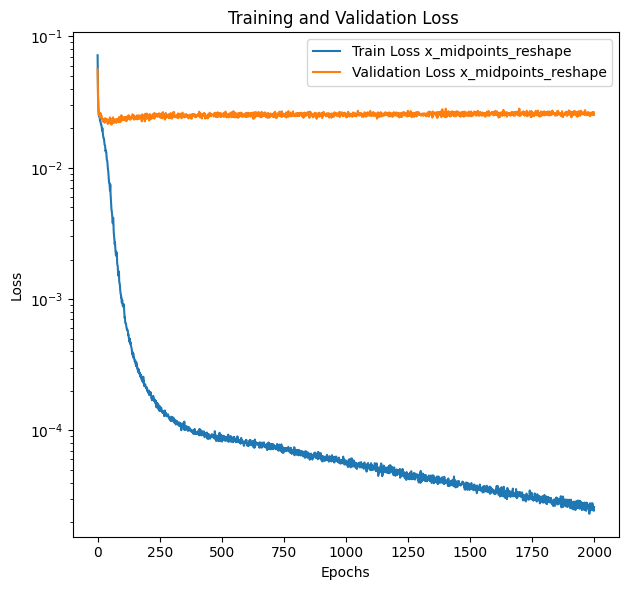

In [16]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
model_builder.model.save("/home/da886/Analysis/13KFixed_Mixed_5_32by32_95indexFor19kernel.keras")
# loaded_model = tf.keras.models.load_model(
# "/home/da886/Analysis/30KFixed_13_SparsespotsrandomSPOTS.keras",
# )

In [19]:
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf

# # Define the function for visualizing midpoints
# def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
#     """
#     Visualizes midpoints on an image without using a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
#     - title: The title of the plot.

#     Returns:
#     None (displays the image with midpoints).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image
#     midpoints_np = midpoints

#     # Denormalize image if necessary (adjust based on your normalization method)
#     denormalized_image = image_np  # Modify if normalization was applied during training

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title(title)

#     # Plot midpoints directly, only if they are not (0, 0)
#     for i, (x, y) in enumerate(midpoints_np):
#         if x >= 0 and y >= 0:  # Only plot if the point is not (0, 0)
#             plt.scatter(x, y, color='red', s=5)

#     plt.show()

# # Create the validation dataset
# # val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# # val_dataset = val_dataset.batch(800)
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
# # inputs,targets = next(iter(train_dataset))
# # outputs = model_builder.model.predict(inputs)
# # # Initialize lists to collect the data
# all_images = []
# all_true_midpoints = []
# all_pred_midpoints = []

# # # Loop through each batch in the validation dataset, predict, and collect results
# # for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

# for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
#     print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
#     # Get the model predictions
#     predictions =model_builder.model.predict(data_batch)

#     # Extend the lists to store data from each batch
#     all_images.extend(data_batch.numpy())  # Store all images
#     all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
#     all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# # Convert lists to arrays for easier indexing
# all_images = np.array(all_images)
# all_true_midpoints = np.array(all_true_midpoints)
# all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


W0000 00:00:1729634555.874463 2936637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729634555.875507 2936637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729634555.875875 2936637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729634555.876224 2936637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729634555.876534 2936637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729634555.876836 2936637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729634555.876921 2936631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729634555.877005 2936610 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729634555.877808 2936637 gp

Processing batch 2, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 3, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 4, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 5, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 6, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 7, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 8, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 9, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
Processing batch 10, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 11, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
Processing batch 12, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 13, batch 

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints_with_gt(image, true_midpoints, pred_midpoints, title="Predicted vs GT Midpoints"):
    """
    Visualizes ground truth and predicted midpoints on an image and draws lines to connect them.

    Parameters:
    - image: A 3D tensor representing the image.
    - true_midpoints: A 2D tensor representing the ground truth midpoint coordinates (x, y).
    - pred_midpoints: A 2D tensor representing the predicted midpoint coordinates (x, y).
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints and lines).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image

    # Ensure that midpoints are in the shape (num_points, 2) for both true and predicted midpoints
    true_midpoints_np = np.reshape(true_midpoints, (-1, 2))
    pred_midpoints_np = np.reshape(pred_midpoints, (-1, 2))

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(image_np, cmap='gray')
    plt.title(title)

    # Plot both ground truth and predicted midpoints
    for i, ((gt_x, gt_y), (pred_x, pred_y)) in enumerate(zip(true_midpoints_np, pred_midpoints_np)):
        if gt_x >= 0 and gt_y >= 0:  # Only plot if the GT point is valid
            plt.scatter(gt_x, gt_y, color='blue', label='Ground Truth' if i == 0 else "", s=30)
            plt.scatter(pred_x, pred_y, color='red', label='Prediction' if i == 0 else "", s=30)

            # Draw a line connecting the GT and predicted points
            plt.plot([gt_x, pred_x], [gt_y, pred_y], color='green', linewidth=1)

    # Add legend only once
    plt.legend()
    plt.show()

# Create the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
train_dataset = train_dataset.batch(800)

# Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# Loop through each batch in the training dataset, predict, and collect results
for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions = model_builder.model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 32, 32)


2024-10-23 15:14:56.909282: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
W0000 00:00:1729696497.069734 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.070713 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.071345 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.071982 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.072732 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.073380 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.074106 1761502 gpu_timer

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


W0000 00:00:1729696497.111935 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.112497 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.113071 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.113650 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.114314 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.115083 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.115985 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.116678 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.117516 1761502 gp

Processing batch 2, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 3, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 4, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 5, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 6, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 7, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 8, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 9, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 10, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 11, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 12, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 13, batch sh

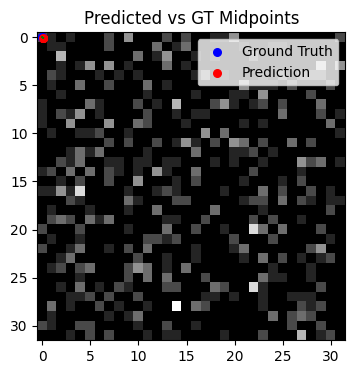

In [21]:
index_to_visualize = np.random.randint(0, len(all_images))
# Visualize the results for the first sample (you can change the index to visualize others)
visualize_midpoints_with_gt(all_images[index_to_visualize ], all_true_midpoints[index_to_visualize ]*np.max(centers), all_pred_midpoints[index_to_visualize ]*np.max(centers))


In [25]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)

In [20]:
all_images.shape,all_pred_midpoints.shape,all_true_midpoints.shape

((9600, 32, 32), (9600, 1, 13, 2), (9600, 1, 13, 2))

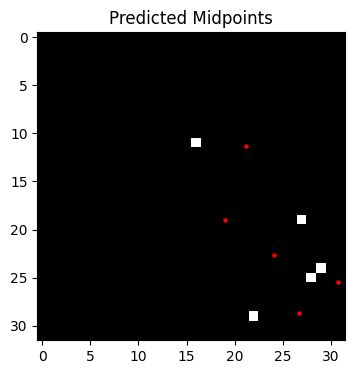

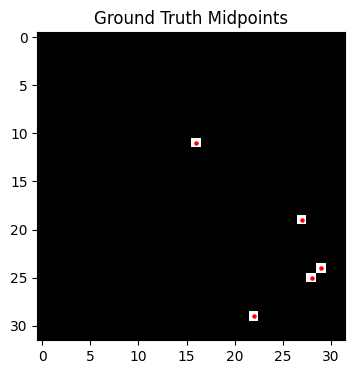

In [23]:

# Select an index to visualize from the entire dataset
index_to_visualize = np.random.randint(0, len(all_images))

# index_to_visualize = 11548
# Visualize the selected image with predicted and true midpoints
visualize_midpoints(all_images[index_to_visualize], all_pred_midpoints[index_to_visualize, 0, :, :] * np.max(centers), title="Predicted Midpoints")
visualize_midpoints(all_images[index_to_visualize], all_true_midpoints[index_to_visualize, 0, :, :] * np.max(centers), title="Ground Truth Midpoints")


In [38]:
np.min(all_pred_midpoints)*np.max(centers),np.max(all_pred_midpoints)*np.max(centers)

(8.843155e-06, 30.997658)

In [39]:
np.min(all_true_midpoints)*np.max(centers),np.max(all_true_midpoints)*np.max(centers)

(0.0, 31.0)

In [40]:
np.min(train_images), np.max(train_images), np.min(train_midpoints)*np.max(centers), np.max(train_midpoints)*np.max(centers)

(0.0, 1.0, 0.0, 31.0)

In [41]:
all_pred_midpoints[2]*np.max(centers),all_true_midpoints[2]*np.max(centers)

(array([[[ 4.2590027,  3.908059 ],
         [27.263153 ,  4.3831873],
         [ 5.8743353,  6.6574388],
         [14.020337 ,  8.760142 ],
         [ 4.1754484, 10.7192545],
         [ 4.123699 , 11.2907295],
         [22.326601 , 11.401616 ],
         [ 7.203351 , 12.493043 ],
         [ 5.814977 , 12.613149 ],
         [21.202332 , 14.556165 ],
         [ 8.0557995, 17.444569 ],
         [ 8.055367 , 18.544151 ],
         [ 5.2744675, 26.596989 ]]], dtype=float32),
 array([[[ 4.,  3.],
         [28.,  6.],
         [ 6.,  7.],
         [14.,  9.],
         [ 4., 10.],
         [ 4., 10.],
         [22., 11.],
         [ 7., 12.],
         [ 6., 14.],
         [21., 15.],
         [ 8., 17.],
         [ 8., 18.],
         [ 5., 28.]]], dtype=float32))

In [35]:
centers

array([[[ 1., 35., 12.],
        [ 1., 63., 52.],
        [ 1., 11., 43.],
        ...,
        [ 1., 10., 33.],
        [ 1., 11., 48.],
        [ 1., 59., 49.]],

       [[ 1.,  5., 24.],
        [ 1., 34., 55.],
        [ 1., 42., 29.],
        ...,
        [ 1.,  2., 55.],
        [ 1., 13., 17.],
        [ 1., 45.,  8.]],

       [[ 1., 38., 36.],
        [ 1., 11., 33.],
        [ 1., 40., 40.],
        ...,
        [ 1., 45.,  5.],
        [ 1.,  8.,  7.],
        [ 1., 55., 37.]],

       ...,

       [[ 1., 50., 18.],
        [ 1., 20., 19.],
        [ 1., 63.,  8.],
        ...,
        [ 1., 32., 44.],
        [ 1., 63., 24.],
        [ 1., 51., 52.]],

       [[ 1.,  6., 33.],
        [ 1., 23., 59.],
        [ 1., 13., 48.],
        ...,
        [ 1., 26., 62.],
        [ 1., 20., 42.],
        [ 1., 53.,  2.]],

       [[ 1., 24., 40.],
        [ 1., 30., 43.],
        [ 1., 38., 55.],
        ...,
        [ 1., 31., 56.],
        [ 1., 21., 50.],
        [ 1., 15.,  6.]]

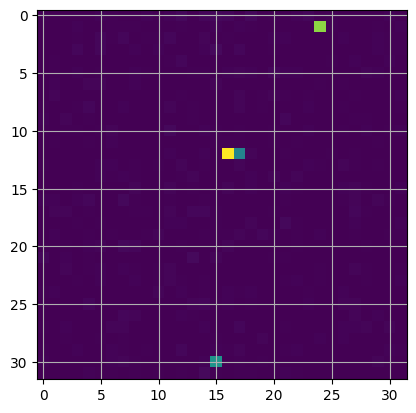

In [44]:
plt.imshow(images[2],)
plt.grid(True)

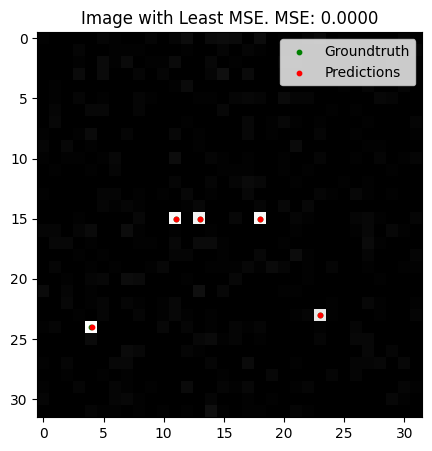

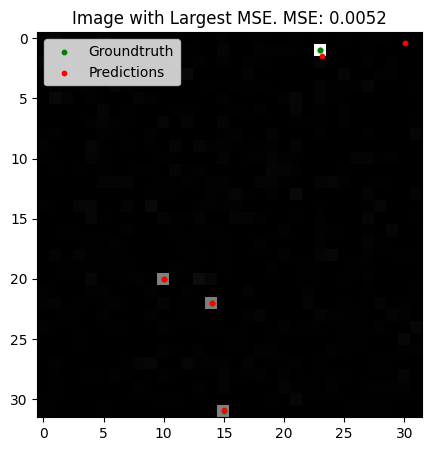

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) **2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')




In [22]:
max_mse_index

5266